In [1]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


In [2]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer,AutoTokenizer
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score,roc_curve, auc,f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
model = AutoModelForSequenceClassification.from_pretrained("voidism/diffcse-bert-base-uncased-trans", num_labels=1)
metric = evaluate.load("accuracy")
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

Some weights of the model checkpoint at voidism/diffcse-bert-base-uncased-trans were not used when initializing BertForSequenceClassification: ['generator.vocab_layer_norm.bias', 'aux_bert.encoder.layer.6.output.LayerNorm.bias', 'aux_bert.encoder.layer.2.attention.self.key.weight', 'generator.vocab_projector.weight', 'aux_bert.encoder.layer.10.attention.self.value.bias', 'aux_bert.encoder.layer.1.attention.self.query.bias', 'generator.distilbert.transformer.layer.0.attention.k_lin.weight', 'aux_bert.encoder.layer.11.attention.output.dense.weight', 'generator.distilbert.transformer.layer.3.ffn.lin2.weight', 'generator.distilbert.transformer.layer.3.sa_layer_norm.weight', 'aux_bert.encoder.layer.5.output.LayerNorm.weight', 'aux_bert.encoder.layer.2.intermediate.dense.bias', 'aux_bert.encoder.layer.3.attention.self.key.bias', 'aux_bert.encoder.layer.0.attention.output.dense.weight', 'aux_bert.encoder.layer.4.attention.output.LayerNorm.weight', 'aux_bert.encoder.layer.10.attention.self.val

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at voidism/diffcse-bert-base-uncased-trans and are newly initialized: ['bert.pooler.dense.weight', 'classifier.weight', 'bert.pooler.dense.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
dataset_test = pd.read_parquet(r'test_result.parquet', engine='fastparquet')
dataset_test

,dataset,method,text,label,SimCSE,SimCSE_roberta,DiffCSE,DiffCSE_roberta
0,archiv,chief,\nThe isotony axiom is natural because we have...,0,0.500,0.470,0.595,0.710
1,archiv,chief,"\nIn the usual situation, all the von Neumann ...",0,0.280,0.375,0.770,0.360
2,archiv,chief,"\nAt the end of this section, we compare our f...",0,0.355,0.420,0.475,0.325
3,archiv,chief,\nBoth of one (unitary) vertex operator algebr...,0,0.595,0.475,0.670,0.685
4,archiv,chief,"\nFor nets of factors, we have introduced a ne...",0,0.485,0.590,0.590,0.390
...,...,...,...,...,...,...,...,...
257450,wikipedia,spin,"""Dead Man's Chest"" was discharged in the Unite...",1,0.745,0.695,0.825,0.950
257451,wikipedia,spin,The wedding of Will Turner and Elizabeth Swann...,1,0.460,0.560,0.485,0.730
257452,wikipedia,spin,Will discovers Jack and the group on an island...,1,0.395,0.560,0.445,0.545
257453,wikipedia,spin,"In Tortuga, Jack enlists another group, includ...",1,0.500,0.640,0.585,0.755


In [5]:
dataset_train = pd.read_parquet(r'train_result.parquet', engine='fastparquet')
dataset_train

,dataset,method,text,label,SimCSE,SimCSE_roberta,DiffCSE,DiffCSE_roberta
0,wikipediaTrain,spin,3D graphics were created using the Nichimen N-...,0,0.160,0.080,0.090,0.095
1,wikipediaTrain,spin,Miyamoto's guiding design philosophy was to in...,0,0.170,0.215,0.100,0.155
2,wikipediaTrain,spin,"""Super Mario 64"" features more puzzles than ea...",0,0.075,0.150,0.110,0.065
3,wikipediaTrain,spin,"""Super Mario 64"" received widespread critical ...",0,0.080,0.115,0.040,0.060
4,wikipediaTrain,spin,"The game has been praised in the gaming press,...",0,0.080,0.070,0.050,0.090
...,...,...,...,...,...,...,...,...
200762,wikipediaTrain,spin,"A ""Roy of the Rovers"" PC amusement was dischar...",1,0.945,0.935,0.995,0.970
200763,wikipediaTrain,spin,On 29 February 2008 it was reported that Titan...,1,0.905,0.825,0.805,0.895
200764,wikipediaTrain,spin,Football-themed stories were a staple of Briti...,1,0.830,0.830,0.875,0.935
200765,wikipediaTrain,spin,Roy of the Rovers initially showed up on 11 Se...,1,0.835,0.780,0.900,0.700


In [ ]:
dataset_test['label'] = dataset_test['label'].astype(float)
dataset_train['label'] = dataset_train['label'].astype(float)

In [7]:
dataset_train, dataset_eval, _, _ = train_test_split(dataset_train, dataset_train, test_size = 0.25,
                                                      shuffle = True, random_state = 42)

In [8]:
train_texts, train_labels = dataset_train['text'].tolist(),dataset_train['label'].tolist()
test_texts, test_labels = dataset_test['text'].tolist(),dataset_test['label'].tolist()
eval_texts, eval_labels = dataset_eval['text'].tolist(),dataset_eval['label'].tolist()

In [9]:
tokenizer = AutoTokenizer.from_pretrained("voidism/diffcse-bert-base-uncased-trans")
train_encodings = tokenizer(train_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
test_encodings = tokenizer(test_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
eval_encodings = tokenizer(eval_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
train_dataset = MyDataset(train_encodings, train_labels)
test_dataset = MyDataset(test_encodings, test_labels)
eval_dataset = MyDataset(eval_encodings, eval_labels)


In [12]:
optim_param = ['adafactor','adamw_torch']

In [13]:
trainer = []
result = []
final_lst = []
for opt in optim_param:
    training_args.optim = opt
    trainer += [Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )]
for i in range(len(trainer)):
    trainer[i].train()
    lst = []
    result_test_pred = trainer[i].predict(eval_dataset)
    for i in range(len(eval_dataset.labels)):
        lst+=[scipy.special.expit(result_test_pred[0][i][0])]
    final_lst+=[lst]
    result += [pd.DataFrame(zip(eval_dataset.labels,lst),columns = ['true','pred'])]

***** Running training *****
  Num examples = 30
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12
  Number of trainable parameters = 109483778
C:\Users\Nikita\AppData\Local\Temp\ipykernel_17940\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,0.655607
2,No log,0.641093
3,No log,0.628939


***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running training *****
  Num examples = 30
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12
  Number of trainable parameters = 109483778
C:\Users\Nikita\AppData\Local\Temp\ipykernel_17940\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,0.588656
2,No log,0.521057
3,No log,0.494219


***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


In [14]:
res = []
for i in range(len(result)):
    res+=[roc_auc_score(result[i]['true'], result[i]['pred'])]
max_value = max(res)
max_index = res.index(max_value)
max_index

1

In [17]:
def find_model(optim_list,max_index):
    i = 0
    best_model = []
    for num_1,opt in enumerate(optim_list):
        print(i,opt)
        if i == max_index:
            best_model= [opt]
            return best_model
        else:
            i+=1
        

In [19]:
best_model = find_model(optim_param,max_index)
best_model

0 adafactor
1 adamw_torch


['adamw_torch']

In [20]:
result_test_pred = trainer[max_index].predict(test_dataset)

***** Running Prediction *****
  Num examples = 10
  Batch size = 8
C:\Users\Nikita\AppData\Local\Temp\ipykernel_17940\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [21]:
lst = []
for i in range(len(test_dataset.labels)):
    lst+=[scipy.special.expit(result_test_pred[0][i][0])]
final_res = pd.DataFrame(zip(test_dataset.labels,lst),columns = ['true','pred'])
final_res

,true,pred
0,1,0.699735
1,0,0.556847
2,0,0.672163
3,0,0.537906
4,1,0.787500
5,1,0.785912
6,1,0.751834
7,1,0.793084
8,1,0.767978
9,0,0.389406


In [22]:
def roc(test_result_old):   
    fpr, tpr, treshold = roc_curve(test_result_old['true'], test_result_old['pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
         label=f'ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Совмещенные ROC-кривые')
    plt.legend(loc="lower right")
    plt.show()

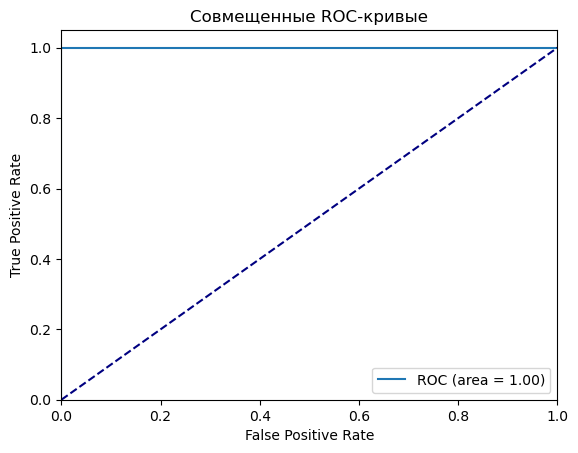

In [23]:
roc(final_res)

In [24]:
def confuns_matrix(train_rezalt_old):
    print(f'f1')
    print(f1_score(train_rezalt_old['true'].tolist(), [int(p>0.5) for p in train_rezalt_old['pred']], average='macro'))
    sns.heatmap(metrics.confusion_matrix(train_rezalt_old['true'],[int(p>0.5) for p in train_rezalt_old['pred']]),annot=True,cmap="Blues",square=True)
    plt.ylabel("label")
    plt.xlabel(f"")
    plt.title(f"Confusion matrix")
    plt.show()

f1
0.6000000000000001


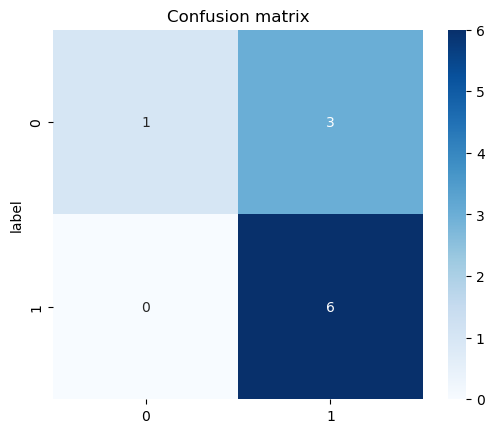

In [25]:
confuns_matrix(final_res)